# Automatic picking of microicequakes

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/tsonpham/ObsSeisHUS2025/blob/master/Day5/D5_Project.ipynb)

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), April 2025

---
## Bonus project

Hello, thank you for being interested in the bonus project. Although everyone is encouraged to complete bonus projects, undergrad students will be considered for bonus points to their final exams. Best of luck!

*Winberry et al. ([2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL086178)) reported a number of micro icequakes happened at the termini of Thwaites glacier recorded by station YT.DNTW. These events were due to the formation of new icebergs from the glacier termini. In this project, you are asked to use one of the phase pickers built in seisbench (with their original weights) to pick as many events as possible.*

*Because this project is within the expertise for many of you, please feel free to experiement with different models and investigate the results. You can view this as an open research question to explore with your own interest.*

If you submit a working code towards completing the task, you will get 50% points. If the code produces correct outcome, you will get 75%. The minimal two-paragraphs on the motivation and additional thoughts will get you to 100%.

Please submit this jupyter notebook to the following form: https://forms.gle/L5QLLYMEnm277bTMA.

In [7]:
# Environemtal setup (uncomment if running in colab)

# !pip install obspy seisbench

In [8]:
#@title Setting notebook resolution
#@markdown Run this cell for better figure resolution

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Retreive waveform data

Lets start by downloading high-frequency high-gain seismic data (HH?) from station YT.DNTW. Winberry et al. (2020) spotted hundreds of micro earthquakes occured from 2018 Nov 02 to 2018 Nov 09. Here, we download data from 5th to 7th as a mini exercise.

In [9]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pathlib import Path

# Downloading data from IRIS if not already downloaded
fname = Path('YT.DNTW.HH.20181105_20181107.mseed')
if not fname.exists():
    # Downloading data from IRIS, high gain data from 
    dstream = Client('IRIS').get_waveforms(network='YT', station='DNTW', location="*", channel='HH?',
                                       starttime=UTCDateTime(2018,11,5), endtime=UTCDateTime(2018,11,7),
                                       attach_response=True)
    # The data is downloaded in miniSEED format
    dstream.remove_response(output='VEL')
    dstream.write(fname, format='MSEED')
else:
    from obspy import read
    dstream = read(fname)

## Application of deep learning phase pickers

Now we apply a deep learning phase picker to `classify` the downloaded data for `P` or `S` arrivals and record outcome to an `output` object.

In [10]:
import seisbench
import seisbench.models as sbm
from obspy import UTCDateTime

dstream.filter("bandpass", freqmin=1.0, freqmax=10.0, corners=2, zerophase=False)

## Loading a model (e.g., PhaseNet) with its original weights
model = sbm.PhaseNet.from_pretrained("original")

# ## Picking the Thwaites glacier station data with the model
pick_threshold = 0.25
output = model.classify(dstream, P_threshold=pick_threshold, S_threshold=pick_threshold)

Next, let use the `output` object to visualize the picked event with a seismogram `dayplot`.

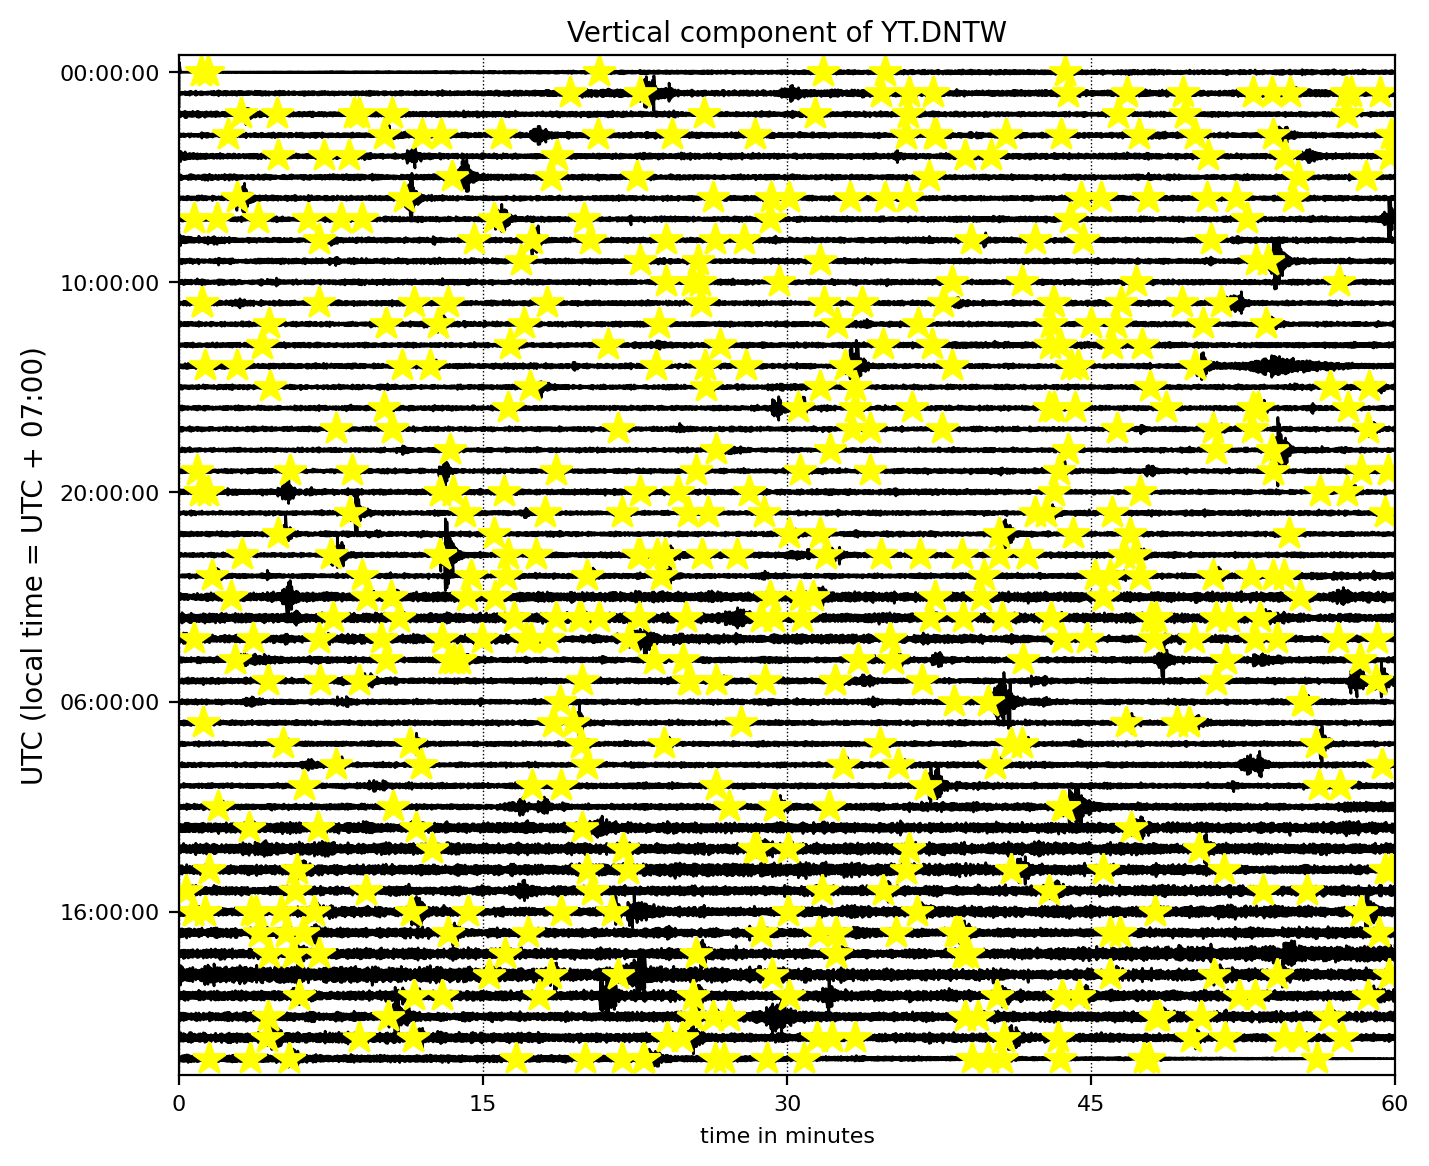

In [11]:
import matplotlib.pyplot as plt

P_picks = [p for p in output.picks if p.phase=='P']
dstream.select(component='Z').plot(type='dayplot',
    starttime=UTCDateTime(2018,11,5), endtime=UTCDateTime(2018,11,7),
    interval=60,
    title='Vertical component of YT.DNTW', 
    size=(800, 600),
    events = [dict(time=p.peak_time) for p in P_picks],
    color='black')

plt.show()

Finally, we can extract the seismic records for individual events for further analysis.

Note that below `evtime = p.peak_time` was used because `PhaseNet` was used when writing this example. You might use different field if you choose to use different models.

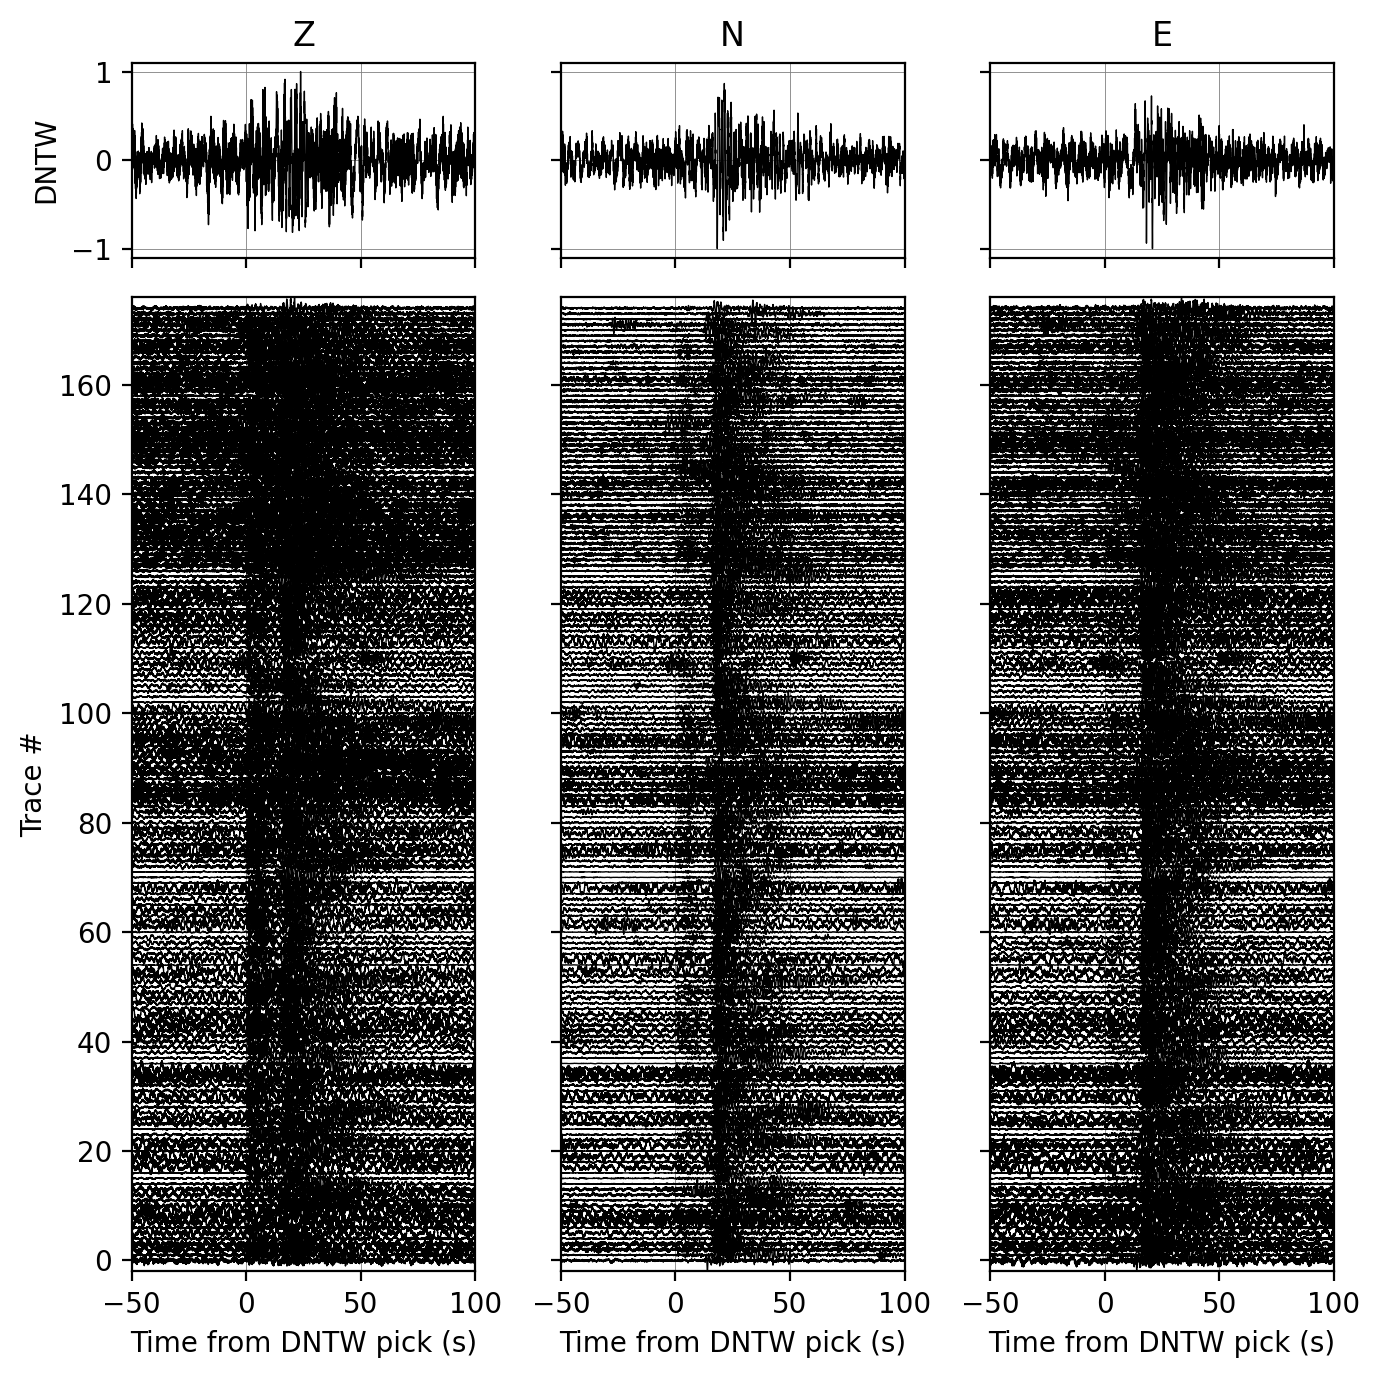

In [12]:
from obspy import Stream
import numpy as np
t_before, t_after = 50, 100

# extract data corresponding to autopicked event
pstream = Stream()
good_P_picks = []
for p in P_picks:
    try:
        evtime = p.peak_time
        if evtime < dstream[0].stats.starttime or evtime > dstream[0].stats.endtime: continue
        tmp = dstream.slice(evtime-t_before, evtime+t_after, nearest_sample=False)
        tmp.detrend('linear')
        # check if window is long enough
        if np.min([_.stats.npts for _ in tmp]) < (t_after+t_before)/tmp[0].stats.delta: continue
        # check vertical component signal to noise ratio
        tr = tmp.select(component='Z')[0]
        mask = (tr.times() >= 50) & (tr.times() <= 100)
        snr = np.median(np.abs(tr.data[mask])) / np.median(np.abs(tr.data[~mask]))
        if snr < 1.25: continue
        # put to the final stack
        pstream.extend(tmp.copy())
        good_P_picks.append(p)
    except ValueError: continue
    
# stack eventwaveform
stack = pstream.copy()
for tr in stack: tr.data /= np.max(np.abs(tr.data))
stack.stack('id', npts_tol=1)
# plot waveform for sanity check
components = 'ZNE'
fig, ax = plt.subplots(2, 3, figsize=(7, 7), sharex=True, sharey='row', gridspec_kw={'height_ratios':[.4, 2]})
stat = 'DNTW'
for _i, comp in enumerate(components):
    tr = stack.select(station=stat, component=comp)[0]
    tvec = np.arange(tr.stats.npts) * tr.stats.delta - t_before
    data = tr.data / np.max(np.abs(tr.data))
    ax[0,_i].plot(tvec, data, lw=.5, c='k')
    ax[0,_i].grid(lw=.3, c='gray')
    for ii, tr in enumerate(pstream.select(station=stat, component=comp)):
        tvec = np.arange(tr.stats.npts) * tr.stats.delta - t_before
        data = tr.data / np.max(np.abs(tr.data))
        ax[1,_i].plot(tvec, 2*data + ii, lw=.5, c='k')
    ax[1,_i].grid(lw=.3, c='gray')
    ax[1,_i].set(xlabel='Time from DNTW pick (s)')
    ax[0,_i].set(title=comp)
ax[1,0].set(xlim=(-t_before, t_after), ylim=(-2, 1+len(pstream.select(component='Z'))), ylabel='Trace #')
ax[0,0].set(ylabel=stat)
fig.tight_layout()
plt.show()